In [ ]:
!pip install -U bitsandbytes

In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
import torch
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
import bitsandbytes as bnb
from transformers import BitsAndBytesConfig

In [ ]:
zip_file_path = '/content/Emotion.zip'
extract_dir = '/content/emotion_dataset/'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

train_file = os.path.join(extract_dir, '/content/emotion_dataset/training.csv')
val_file = os.path.join(extract_dir, '/content/emotion_dataset/validation.csv')
test_file = os.path.join(extract_dir, '/content/emotion_dataset/test.csv')

train_df = pd.read_csv(train_file)
val_df = pd.read_csv(val_file)
test_df = pd.read_csv(test_file)
print(f"train shape: {train_df.shape}, validation shape: {val_df.shape}, test shape: {test_df.shape}")

train shape: (16000, 2), validation shape: (2000, 2), test shape: (2000, 2)


In [ ]:
#label mappings
emotion_label_mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
target_labels = ['anger', 'fear', 'joy', 'sadness', 'love', 'surprise']
target_indices = [key for key, value in emotion_label_mapping.items() if value in target_labels]
remap_labels = {idx: i for i, idx in enumerate(target_indices)}

#remap labels
train_df = train_df[train_df['label'].isin(target_indices)]
val_df = val_df[val_df['label'].isin(target_indices)]
test_df = test_df[test_df['label'].isin(target_indices)]
train_df['label'] = train_df['label'].map(remap_labels)
val_df['label'] = val_df['label'].map(remap_labels)
test_df['label'] = test_df['label'].map(remap_labels)

In [ ]:
#tokenizer and model
MODEL_NAME = "bigscience/bloomz-560m"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print("Padding token set to EOS token.")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print("Padding token was added manually.")

tokenizer.padding_side = "right"

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(target_labels))
model.config.pad_token_id = tokenizer.pad_token_id
model.resize_token_embeddings(len(tokenizer))

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloomz-560m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(250680, 1024)

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['label'].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = EmotionDataset(train_df, tokenizer)
val_dataset = EmotionDataset(val_df, tokenizer)
test_dataset = EmotionDataset(test_df, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
#4-bit quantization using BitsAndBytesConfig
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

In [ ]:
from transformers import AutoModelForSequenceClassification

base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(target_labels),
    device_map=None,
    torch_dtype="auto",
    low_cpu_mem_usage=False
)

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloomz-560m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)
model = get_peft_model(base_model, peft_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BloomForSequenceClassification(
      (transformer): BloomModel(
        (word_embeddings): Embedding(250880, 1024)
        (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (h): ModuleList(
          (0-23): 24 x BloomBlock(
            (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (self_attention): BloomAttention(
              (query_key_value): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=3072, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
              

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=len(train_dataloader) * 5)

def train(model, dataloader, optimizer, scheduler):
    model.train()
    for batch in tqdm(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels)
    return true_labels, predictions

In [ ]:
for epoch in range(5):
    print(f"Epoch {epoch+1}")
    train(model, train_dataloader, optimizer, scheduler)

true_labels, predictions = evaluate(model, test_dataloader)

Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print("Classification report:")
print(classification_report(true_labels, predictions, target_names=target_labels))

Classification report:
              precision    recall  f1-score   support

       anger       0.95      0.94      0.95       581
        fear       0.92      0.94      0.93       695
         joy       0.81      0.79      0.80       159
     sadness       0.93      0.90      0.91       275
        love       0.89      0.90      0.89       224
    surprise       0.76      0.67      0.71        66

    accuracy                           0.91      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.91      0.91      0.91      2000



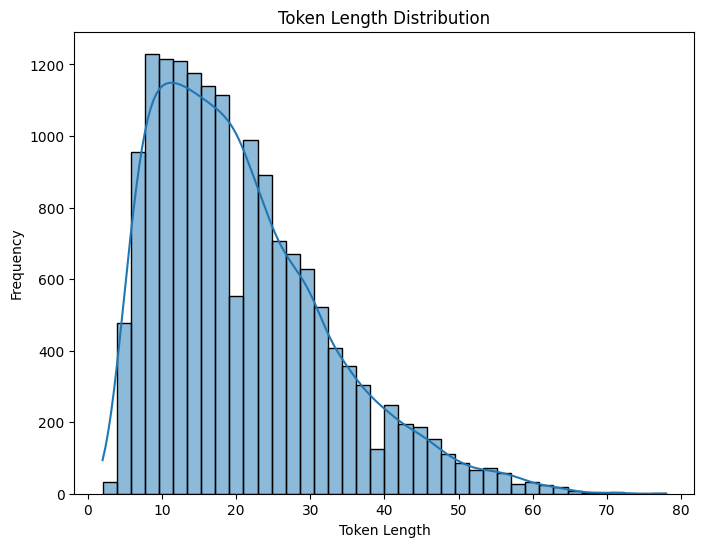

In [ ]:
token_lens = [len(tokenizer.encode(text, max_length=512, truncation=True)) for text in train_df['text']]
plt.figure(figsize=(8,6))
sns.histplot(token_lens, bins=40, kde=True)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Token Length Distribution")
plt.show()

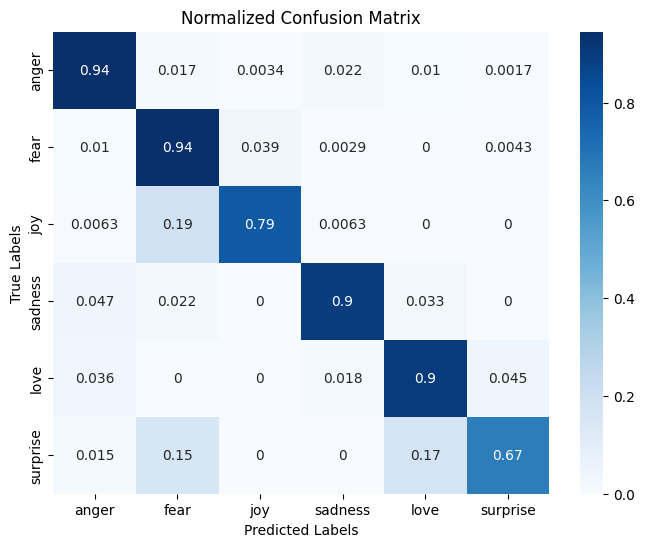

In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions, normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=target_labels, yticklabels=target_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
output_dir = "/content/QLoRA(bloomz-560m)"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/QLoRA(bloomz-560m)


In [ ]:
from google.colab import files
import shutil

shutil.make_archive("QLoRA(bloomz-560m)", 'zip', output_dir)

files.download("QLoRA(bloomz-560m).zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>